# Overview

This notebook examines Animal Feeding Operation (AFO) records from the [Iowa Geospatial Data Clearinghouse](https://https://geodata.iowa.gov/documents/abfbd972640d4e87b6c48dc669775767/about). These records list "Animal feeding operation data including active facilities with 300 animal units or greater from the State of Iowa's AFO Database". Such facilities represent: "medium and large animal feeding operation sites as defined by the U.S. Environmental Protection Agency (EPA). The EPA defines a medium site as a facility with a capacity of 300-999 animal units and a large site as a facility with a capacity of 1,000 or more animal units."

The aim of the notebook is to understand the characteristics of buildings associated with medium and large pig and poultry CAFOs. If possible, this information will be used to help create useful model training datasets from lists of CAFO locations where no animal number information is available (e.g. the Mexico dataset). The notebook also creates a standardized Iowa dataset that can also be used for model training, if desired.

There are other CAFO datasets for the US, but the Iowa one is especially valuable because it includes the number of animal units present on each farm, by species and subtypes. That information is not present in the Delmarva poultry house database or the North Carolina lagoons database.



## Setup

In [ ]:
try:
  import unidecode
except ModuleNotFoundError:
  !pip install pyogrio==0.7.2 geopandas==0.14.3 unidecode

In [ ]:
%load_ext autoreload
%autoreload 2

import os, sys
from IPython.core.magic import register_cell_magic
from google.colab import drive
import ee
import geemap.foliumap as geemap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import fiona
import pyproj
import pyarrow

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"
pd.options.display.float_format = '{:.0f}'.format

In [ ]:
ee.Authenticate()
ee.Initialize(project="215656163750")
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils, explore

@register_cell_magic
def skip(line, cell):
    return

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## What's in the files?

Three geospatial layers are available:

0. 'animal_feeding_operations': Contains information about both open feedlots and confinement facilities, including whether they have "unformed manure storage", which basically means [lagoon-type structures](https://www.lawserver.com/law/state/iowa/ia-code/iowa_code_459-102).
1. 'AFO_open_feedlots': Contains information about open feedlots, which isn't what we're looking for. Ignore this layer.
2. 'AFO_confinements': Contains information about confinement facilities. This is the most relevant layer.

Each layer contains information about quantities of animals:

* There are columns for various subtypes of animals, as well as columns entitled AnimalUnitsByOperation and TotalAnimalUnitsByFacility.
* AnimalUnitsByOperation appears to be the sum of the animal subtypes in each row
* However, sometimes animal subtype numbers are all 0, and only AnimalUnitsByOperation contains a number. In these cases we cannot know what type(s) of animals the facility contains.
* TotalAnimalUnitsByFacility can exceed AnimalUnitsByOperation. It appears that this happens when a facility contains open feedlots in addition to confinement structures. This seems to be surprisingly common.

* Here's an example for Facility 70891:

  * In Layer 0
    * OpeartionTypes [sic]: 'Confinement/Open Feedlot'
    * TotalAnimalUnitsByFacility: 1000.
    * Cattle_Beef_Finishing: 900.
    * Swine_Nursery 100.
    * Unformed_Manure_Storage: No
  * In Layer 1
    * OperationType: 'Open Feedlot'
    * AnimalUnitsByOperation 700.
    * TotalAnimalUnitsByFacility 1000.
    * Cattle_Beef_Finishing 700.
    * Swine_Nursery: 0.
  * In Layer 2
    * OperationType: 'Confinement'
    * AnimalUnitsByOperation: 300.0
    * TotalAnimalUnitsByFacility: 1000.0
    * Cattle_Beef_Finishing: 200.0
    * Swine_Nursery: 100.0

* In this facility there are 1000 animal units. Of these, 100 units of pigs and 200 units of cattle are in confinement operations, while 700 units of cattle are in open feedlots.

* You can look up info about this facility [online](https://programs.iowadnr.gov/animalfeedingoperations/FacilitySummary.aspx?FacilityId=70891). The pig building is described as "Swine nursery with concrete pit", the cattle confinement as "Deep Pack Bedded Buildings", and the manure storage as "Below Building Pits - Deep". The facility has no unformed manure storage.



Facility 70891 looks like this. You can see cattle around some of the buildings, while the pigs are presumably in other buildings. Note that the coordinates associated with this farm represent the farm entrance, rather than any of the buildings.

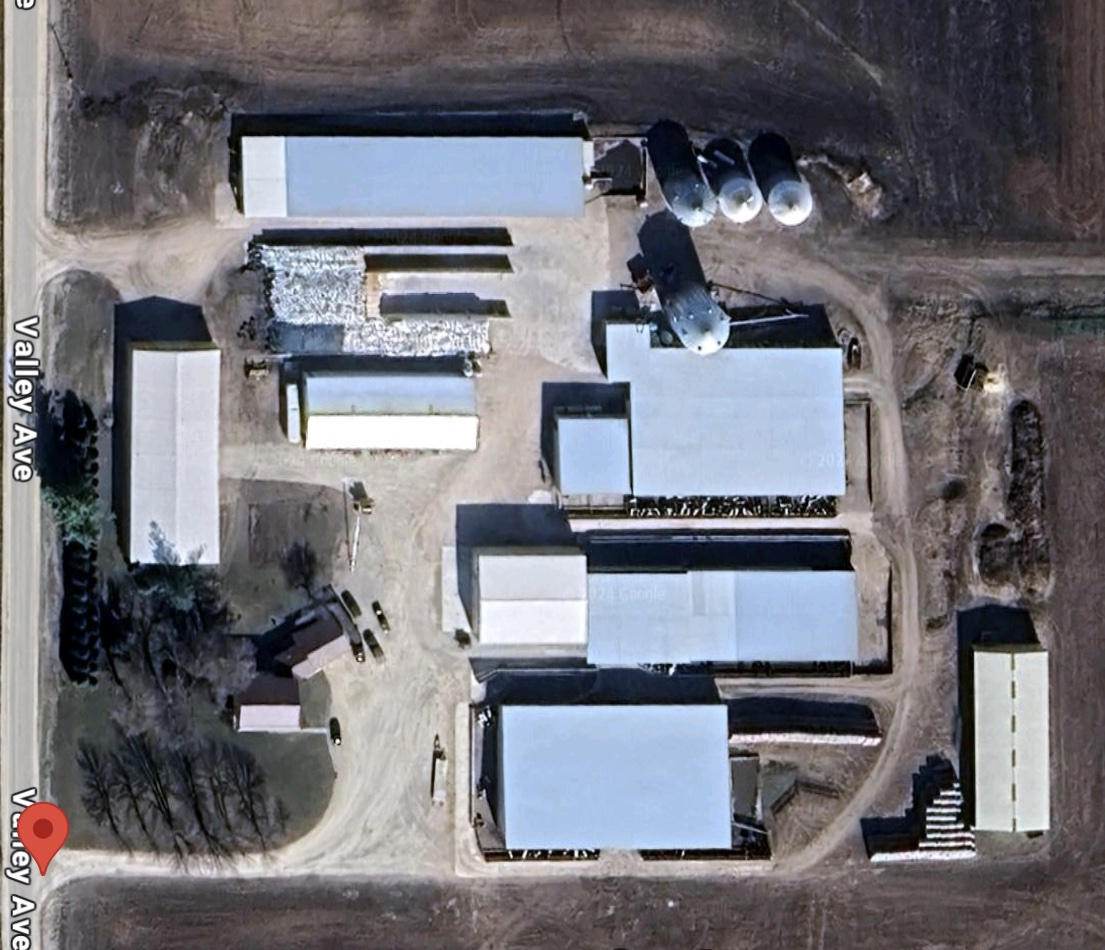

## Animal units vs animal numbers

The confinement layer contains animal *units*, not animal *numbers*. For consistency with other datasets we will need to convert between the two. Animal unit definitions are given [here](https://www.lawserver.com/law/state/iowa/ia-code/iowa_code_459-102) and [here](https://www.iowadnr.gov/Portals/idnr/uploads/afo/rules/Ch65%20clean%20copy.pdf) for various animal types:

*   Butcher or breeding swine weighing more than fifty-five pounds:   0.400
*   Swine weighing fifteen pounds or more but not more than fifty-five pounds:   0.100
*   Turkeys weighing one hundred twelve ounces [7 lbs] or more:   0.018
*   Turkeys weighing less than one hundred twelve ounces [7 lbs]:   0.0085
*   Chickens weighing forty-eight ounces [3 lbs] or more:   0.010
*   Chickens weighing less than forty-eight ounces [3 lbs]:   0.0025
*   Ducks: 0.04

The correspondence between these definitions and the columns in the state records isn't always clear. For example, the above definitions don't say how many AU each pig in a "swine nursery" counts as ([this link](https://www.google.com/url?q=https%3A%2F%2Fprograms.iowadnr.gov%2Fanimalfeedingoperations%2FFacilitySummary.aspx%3FFacilityId%3D70891) shows that it is 0.1 AU). So, we will have to make some assumptions/best guesses in the following dictionary.


In [ ]:
au_dict = {'Chicken_Layer_or_Broiler__3_lbs_or_more_': 0.010,\
           'Chicken_Pullet__less_than_3_lbs_': 0.0025,\
           'Ducks': 0.040,\
           'Swine_Gestation____Boars_': 0.400,\
           'Swine_Gilts____Isolation_': 0.400,\
           'Swine_Grow_to_Finish': 0.400,\
           'Swine_Nursery': 0.100,\
           'Swine_Sow_and_Litter': 0.400,\
           'Swine_Wean_to_Finish': 0.400,\
           'Turkey_Finisher__7lbs_or_more_': 0.018,\
           'Turkey_Poult_or_Brooder__less_than_7_lbs_': 0.0085}

## Read and tidy the data

Here we combine all pig subtypes and all bird subtypes into just pig and poultry categories, and do various other things to make the data easier to handle/consistent with other datasets. We end up with four types of farm:

*   Pigs only
*   Poultry only
*   Mixed (any animal combination)
*   Unknown CAFO (animals not specified)

I envisage the first two categories being the useful ones, because I've been assuming that large CAFOs in LMICs will primarily contain only pigs or only birds. However, going into this work I thought that would also be true for the Iowa farms, and I was wrong about that. So, we won't exclude any of those farm types just yet.

In [ ]:
gdb_path = "/content/drive/MyDrive/CAFO_data/USA/Iowa.gdb"
layers = fiona.listlayers(gdb_path)

# Read layer 0, "animal_feeding_operations", just to get info about
# "unformed manure storage"
gdf0 = gpd.read_file(gdb_path, layer=layers[0])

# Layer 2, "AFO_confinements", contains the rest of the info that we need
cafos = gpd.read_file(gdb_path, layer=layers[2])

# Combine animal types into simply pigs and poultry as appropriate
pig_cols = [col for col in cafos.columns if 'Swine' in col]

birds = ['Chicken', 'Turkey', 'Duck']
poultry_cols = [col for col in cafos.columns if any(bird in col for bird in birds)]

# Create new columns containing pig and poultry **units**
cafos['Animal units (pigs)'] = cafos[pig_cols].sum(axis=1).astype(int)
cafos['Animal units (poultry)'] = cafos[poultry_cols].sum(axis=1).astype(int)

# Create farm type and CAFO class columns, and also a column to record animal
# units in cases where no numbers are given for individual animal types
for idx, row in cafos.iterrows():

  # Farms with poultry but not pigs
  if row['Animal units (pigs)'] == 0 and row['Animal units (poultry)'] != 0:

    # Are there any other animal types?
    delta = row['AnimalUnitsByOperation'] - row['Animal units (poultry)']

    # No
    if delta < 1:
      cafos.loc[idx, 'Farm type'] = 'Poultry'
      cafos.loc[idx, 'Animal units (unspecified/other)'] = 0
    # Yes
    else:
      cafos.loc[idx, 'Farm type'] = 'Mixed'
      cafos.loc[idx, 'Animal units (unspecified/other)'] = delta

  # Farms with pigs but not poultry
  elif row['Animal units (pigs)'] != 0 and row['Animal units (poultry)'] == 0:

    delta = row['AnimalUnitsByOperation'] - row['Animal units (pigs)']

    if delta < 1:
      cafos.loc[idx, 'Farm type'] = 'Pig'
      cafos.loc[idx, 'Animal units (unspecified/other)'] = 0
    else:
      cafos.loc[idx, 'Farm type'] = 'Mixed'
      cafos.loc[idx, 'Animal units (unspecified/other)'] = delta

  # Farms with both pigs and poultry (and possibly other animals)
  elif row['Animal units (pigs)'] != 0 and row['Animal units (poultry)'] != 0:

    cafos.loc[idx, 'Farm type'] = 'Mixed'
    delta = row['AnimalUnitsByOperation'] - row['Animal units (pigs)'] -\
            row['Animal units (poultry)']

    if delta < 1:
      cafos.loc[idx, 'Animal units (unspecified/other)'] = 0

    else:
      cafos.loc[idx, 'Animal units (unspecified/other)'] = delta

  # Farms with no numbers given for any animal subtype
  else:
    cafos.loc[idx, 'Farm type'] = 'Unknown'
    cafos.loc[idx, 'Animal units (unspecified/other)'] = row['AnimalUnitsByOperation']

  # Create CAFO class column. I don't know whether this is correct for farms
  # of type=mixed or unknown, though (does the threshold refer to operations
  # or facilities in those cases?)
  if row['AnimalUnitsByOperation'] >= 1000:
    cafos.loc[idx, 'CAFO class'] = 'Large'
  else:
    cafos.loc[idx, 'CAFO class'] = 'Medium'

# Convert original animal class columns from animal units to animal numbers
for column in au_dict:
  cafos[column] = cafos[column] / au_dict[column]

# Create columns with pig and poultry **numbers**
cafos['Number of pigs'] = cafos[pig_cols].sum(axis=1)
cafos['Number of poultry'] = cafos[poultry_cols].sum(axis=1)
cafos['Number of animals'] = cafos['Number of pigs'] + cafos['Number of poultry']

# Drop the original animal type columns
for column in cafos.columns:
  if 'Swine' in column or any(bird in column for bird in birds):
    cafos.drop(columns=[column], inplace=True)

# Drop other not-needed columns
to_drop = ["FacilityName", "Address", "City", "State", "Zip", "County",\
           "FieldOffice", "PlanType", "Last_Plan_Date", "First_Plan_date",\
           "CollectedBy", "CollectionDate", "CollectionMethod",\
           "LocationComment", "OperationType", "geometry", "FacilityID"]
cafos.drop(columns=to_drop, inplace=True)
for column in cafos.columns:
  for animal in ["Cattle", "Cow", "Horses", "Goats", "Sheep", "Fish"]:
    if animal in column:
      try:
        cafos.drop(columns=[column], inplace=True)
      except KeyError:
        pass

# Get geometry from lat and long (original geometry is eastings + northings)
geometry = gpd.points_from_xy(cafos.Longitude, cafos.Latitude, crs="EPSG:4326")
cafos["geometry"] = geometry
cafos.drop(columns=["Latitude", "Longitude"], inplace=True)

# Change pig and poultry quantities from 0 to NaN for unknown farm types
# Acknowledge we don't know/haven't calculated animal numbers for unknown and
# mixed farms
for column in ['Animal units (pigs)', 'Animal units (poultry)',\
               'Number of pigs', 'Number of poultry', 'Number of animals']:
  cafos.loc[cafos['Farm type'] == 'Unknown', column] = np.nan
cafos.loc[cafos['Farm type'] == 'Mixed', 'Number of animals'] = np.nan


## Basic info and stats

A few sanity checks and other observations:

*  There are about 3500 large pig and poultry CAFOs. This is not too far off the [EWG count](https://https://www.ewg.org/interactive-maps/2020-iowa-cafos/) of 3963 in 2019.
*  There are about 26 million pigs, similar to the 23 million reported for 2017 (Ag Census quoted by [EWG](https://https://www.ewg.org/interactive-maps/2020-iowa-cafos/))
*  There are many more pig CAFOs than chicken ones, which is also consistent with the EWG report.
*  The farm with 6 pigs isn't an error, it's in the database because it has a total of 518 animal units overall (the rest are presumably in the Open Feedlot layer).
* The median pig farm is just a tiny bit short of the large CAFO threshold. This probably reflects farms wanting to avoid being classified as large CAFOs and subject to whatever regulations go along with that.
* Still, about 40% of the pig farms are large CAFOs
* All of the poultry farms are above the medium CAFO threshold, and about 34% of them are large CAFOs.



,Farms,Large CAFOs,Max (num),Med (num),Min (num),Max (AU),Med (AU),Min (AU)
Pig,8672,3465,37200,2496,16,12122,996,6
Poultry,228,77,8000000,97618,17000,80000,813,300
Mixed,142,71,NaN,NaN,NaN,7859,1000,190
Unknown,479,83,NaN,NaN,NaN,14000,499,5


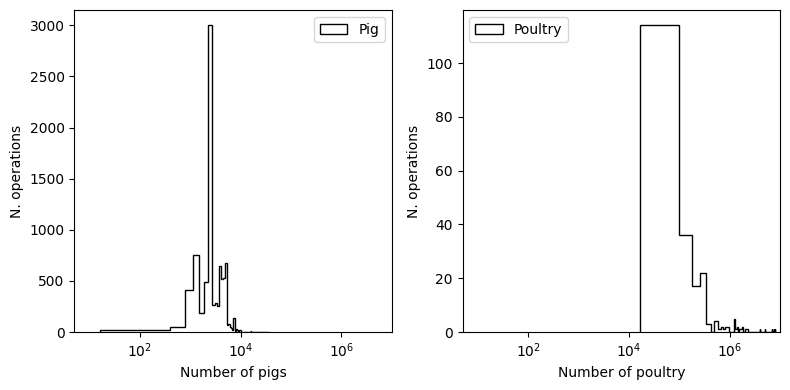

In [89]:

def describe(farm_type, animal_col, ax, df):

  farms = cafos[cafos["Farm type"] == farm_type]
  df.loc[farm_type, 'Farms'] = len(farms)
  df.loc[farm_type, 'Large CAFOs'] = len(farms[farms['CAFO class'] == 'Large'])

  if farm_type not in ['Mixed', 'Unknown']:
    df.loc[farm_type, 'Max (num)'] = farms[animal_col].max()
    df.loc[farm_type, 'Med (num)'] = farms[animal_col].median()
    df.loc[farm_type, 'Min (num)'] = farms[animal_col].min()

    bins = np.linspace(farms[animal_col].min(), farms[animal_col].max(), 100)
    ax.hist(farms[animal_col], bins=bins, color='k', histtype='step',\
            label=farm_type)
    ax.legend()
    ax.set_xscale('log')
    ax.set_xlim(5, 1e7)
    ax.set_xlabel(animal_col)
    ax.set_ylabel("N. operations")

  df.loc[farm_type, 'Max (AU)'] = farms['AnimalUnitsByOperation'].max()
  df.loc[farm_type, 'Med (AU)'] = farms['AnimalUnitsByOperation'].median()
  df.loc[farm_type, 'Min (AU)'] = farms['AnimalUnitsByOperation'].min()

  return df

# Stats and histograms for pig and poultry farms
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
df = pd.DataFrame()
df = describe('Pig', "Number of pigs", ax0, df)
df = describe('Poultry', "Number of poultry", ax1, df)
df = describe('Mixed', "Number of animals", None, df)
df = describe('Unknown', "Number of animals", None, df)

display(df)
plt.tight_layout()

## Associate farms with buildings

Now, we first find all the buildings larger than some minimum size that are within 150 m of the farm coordinates. If there are no buildings, that farm is dropped from the dataset because it's not much use for model training if its coordinates are farm from where the farm buildings actuall are.

Then, assuming that the largest building on a farm is characteristic of the animal housing, we filter the dataset down to just the largest building within 150 m of each farm's coordinates. If this assumption is correct, filtering the dataset like this allows us to investigate the characteristics of the animal housing without 'contamination' from other buildings on the farm.

In the process of doing all this, we also create a dataset of all the buildings larger than our minimum size that are > 1000 km from any farm coordinates. This larger distance threshold helps to exclude buildings associated with farms even if their coordinates don't coincide with their buildings. Also, as we haven't yet dropped "Mixed" and "Unknown" farms, the not-farm buildings won't be contaminated with confinement buildings on those farms (assuming the Iowa records are complete). They could be contaminated with small CAFOs (< 300 AU), at least in theory, so that's something to watch out for.

In [ ]:
min_building_size = 200

In [ ]:
%%skip
# Read the Iowa state shapefile and find all buildings above 200 sq m
# We have to exclude smaller buildings to keep the data volume manageable

iowa = gpd.read_file('/content/drive/MyDrive/CAFO_data/USA/cb_2021_us_state_5m.shp')
iowa = iowa[iowa['NAME'].str.match('Iowa')]
iowa_geom = geemap.geopandas_to_ee(iowa[['geometry']])

buildings = (
      ee.FeatureCollection(f"projects/sat-io/open-datasets/VIDA_COMBINED/USA")
      .filter(ee.Filter.gt('area_in_meters', min_building_size))
      .filterBounds(iowa_geom)
)

In [ ]:
%%skip
# Save the buildings to a file for future use. This is time-consuming so leave
# this cell commented out unless there's a reason to recreate the file.

utils.write_to_file(buildings, f"IA_{min_building_size}m2", 'USA')
utils.ee_task_status()

In [ ]:
# Read the data into a geodataframe (takes about 1.5 mins, ~700,000 buildings)

buildings = gpd.read_file(f"/content/drive/MyDrive/CAFO_data/USA/IA_{min_building_size}m2.geojson")
buildings.rename(columns={"area_in_meters": "Area (sq m)"}, inplace=True)
print(f"There are {len(buildings)} buildings > {min_building_size} sq m")

There are 738413 buildings > 200 sq m


In [ ]:
# Find all the buildings that are within <farm_dist> m of a farm, and those
# that are more than <not_farm_dist> away

crs = "EPSG:5070"
farm_dist = 150
not_farm_dist = 1000
farm_buildings, other_buildings = explore.join_farms_and_buildings(cafos,\
                                                                  buildings,\
                                                                  farm_dist,\
                                                                  not_farm_dist,\
                                                                  crs)

print(f"There are {len(farm_buildings)} buildings within {farm_dist} m of farm coords ")
print(f"There are {len(other_buildings)} buildings >{not_farm_dist} m from\
 farm coords (any farm type) ")

There are 23817 buildings within 150 m of farm coords 
There are 661230 buildings >1000 m from farm coords (any farm type) 


In [ ]:
# See how many farms have been "lost", probably because their coordinates
# don't coincide with where the actual buildings are.

new_total = 0
for farm_type in ["Pig", "Poultry", "Mixed", "Unknown"]:
  n = len(cafos[cafos["Farm type"] == farm_type])
  print(f"Started with {n} farms of type {farm_type}")

  n = len(farm_buildings[farm_buildings["Farm type"] == farm_type].\
             groupby(by="Parent coords"))
  print(f" -- {n} are associated with buildings > {min_building_size} sq m")
  new_total += n

print(f"There is now a total of {new_total} farms")

Started with 8672 farms of type Pig
 -- 7119 are associated with buildings > 200 sq m
Started with 228 farms of type Poultry
 -- 203 are associated with buildings > 200 sq m
Started with 142 farms of type Mixed
 -- 118 are associated with buildings > 200 sq m
Started with 479 farms of type Unknown
 -- 412 are associated with buildings > 200 sq m
There is now a total of 7852 farms


In [ ]:
# Calculate the lengths and aspect ratios of those buildings
farm_buildings = explore.get_dimensions(farm_buildings, crs=crs)

In [ ]:
# As we have done for other datasets, we'll drop all but the largest building
# per farm

max_farm_bldgs = farm_buildings.sort_values('Area (sq m)', ascending=False)\
                              .drop_duplicates(['Parent coords'])
print(f"{len(farm_buildings)} buildings --> {len(max_farm_bldgs)} buildings")

23817 buildings --> 7850 buildings


## Animal housing characteristics

First, let's look at some simple histograms and stats. The next cell creates histograms of pig and poultry buildings (area, length, and aspect ratio), for all farm sizes and also separated into medium and large CAFOs. The first thing that stands out is that the poultry buildings tend to be larger and narrower than the pig housing. That makes sense in terms of what I've read about ventilation mechanisms - poultry barns rely on cross-currents of air, so narrow designs work better, while pig farms... work differently.

For a single animal type, the difference between medium and large CAFOs is much smaller. If you want to make a larger farm, you probably add more buildings rather than  making larger and larger buildings.

At the large end of the building size distribution, buildings >4000 sq m are often actually multiple buildings that the MS-Google building footprint database has glommed together into a single structure.

I'm more interested in the small end of the distribution, anyway. The larger the buildings that house animals on a CAFO, the easier it will probably be to identify them in the satellite data. These plots only contain farms with buildings > 200 sq m (we made that cutoff earlier to keep the data volumne manageable), so the minimum building size isn't very meaningful. However, given that the Area histograms peak well away from the small-size cutoff, the 5%-ile size seems like a useful number. Based on that number, it seems like very few animal buildings on pig CAFOs will have area < 450 sq m or so, and very few poultry CAFO buildings will be < 700 sq m.

If that's also true in other locations, then if we locate and classify only buildings larger than those thresholds, we should still expect to detect most CAFOs. Whether that is in fact true is something we will examine using the datasets from Chile and other places.


=====Pigs=====


,N. farms,5%-ile area (sq m),50%-ile area (sq m)
All CAFOs,7119,491,1170
Medium CAFOs,3983,434,1054
Large CAFOs,3136,663,1436



=====Poultry=====


,N. farms,5%-ile area (sq m),50%-ile area (sq m)
All CAFOs,203,723,3685
Medium CAFOs,132,677,3256
Large CAFOs,71,1056,3859


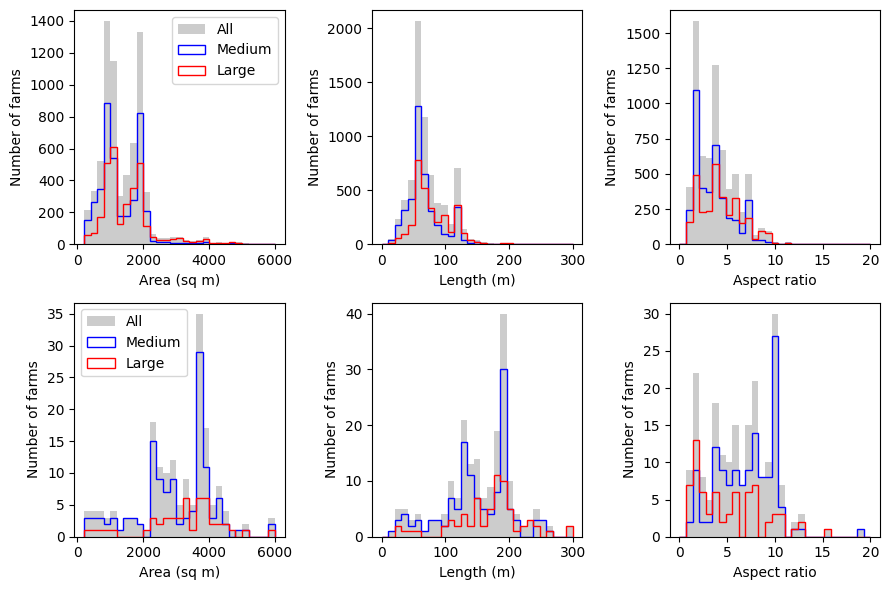

In [79]:

def building_stats(farm_type, bins, axes):

  print(f"\n====={farm_type}=====")

  df = pd.DataFrame()
  edit = farm_type.replace('s', '')

  temp = max_farm_bldgs[max_farm_bldgs["Farm type"] == edit]
  medium = temp[temp["CAFO class"] == "Medium"]
  large = temp[temp["CAFO class"] == "Large"]

  for size, label, color, histtype in zip([temp, medium, large],\
                                          ["All", "Medium", "Large"],\
                                          ["0.8", "b", "r"],\
                                          ["stepfilled", "step", "step"]):
    df.loc[f"{label} CAFOs", f"N. farms"] = len(size)
    df.loc[f"{label} CAFOs", "5%-ile area (sq m)"] = size["Area (sq m)"].quantile(0.05)
    df.loc[f"{label} CAFOs", "50%-ile area (sq m)"] = size["Area (sq m)"].quantile(0.5)

    for col, ax in zip(["Area (sq m)", "Length (m)", "Aspect ratio"],\
                       [axes[0], axes[1], axes[2]]):
      ax.hist(size[col], bins=bins[col], histtype=histtype, color=color,\
                 label=label)
      if col == "Area (sq m)":
        ax.legend()
      ax.set_xlabel(col)
      ax.set_ylabel("Number of farms")

  display(df)

  return df

bins = {}
bins['Area (sq m)'] = np.linspace(min_building_size, 6000, 30)
bins['Length (m)'] = np.linspace(0, 300, 30)
bins['Aspect ratio'] = np.linspace(0, 20, 30)

_, (ax0, ax1) = plt.subplots(2, 3, figsize=(9, 6))
pig_stats = building_stats("Pigs", bins, ax0)
poultry_stats = building_stats("Poultry", bins, ax1)
plt.tight_layout()

Here are a couple more plots, but I'm not sure they're very useful, may remove.

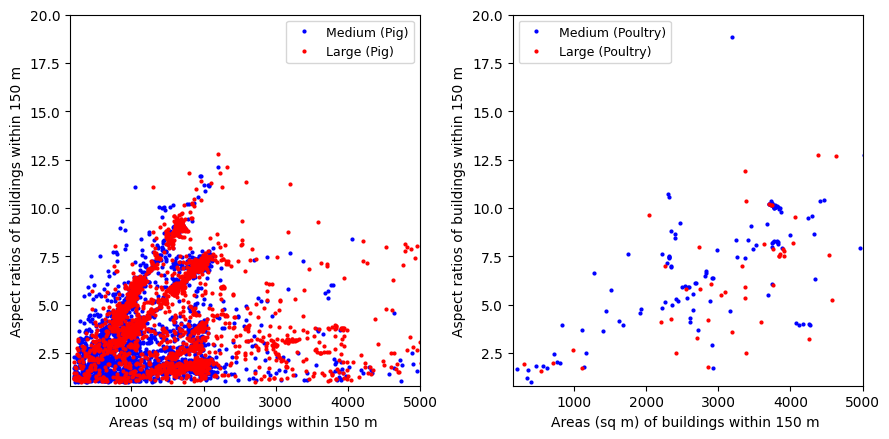

In [76]:
# Plot aspect ratio vs area

_, axes = plt.subplots(1, 2, figsize=(9, 4.5))

for ax, farm_type in zip(axes, ['Pig', 'Poultry']):

  to_plot = max_farm_bldgs[max_farm_bldgs["Farm type"] == farm_type]
  medium = to_plot[to_plot["CAFO class"] == "Medium"]
  large = to_plot[to_plot["CAFO class"] == "Large"]
  ax.plot(medium["Area (sq m)"], medium["Aspect ratio"], 'bo', ms=2,\
          label=f"Medium ({farm_type})")
  ax.plot(large["Area (sq m)"], large["Aspect ratio"], 'ro', ms=2,\
          label=f"Large ({farm_type})")

  ax.legend(fontsize=9)
  ax.set_xlim(min_building_size-50, 5000)
  ax.set_ylim(0.8, 20)
  ax.set_xlabel(f'Areas (sq m) of buildings within {farm_dist} m ')
  ax.set_ylabel(f'Aspect ratios of buildings within {farm_dist} m')

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/CAFO_data/Analysis/Iowa_aspect_area.png")

## Create the not-farm sample

In [80]:
# The not-farm sample will match the Area distribution of the combined pig and
# poultry df
sampled = explore.stratified_sample(max_farm_bldgs, other_buildings, 'Area (sq m)',\
                                 bins=bins['Area (sq m)'])

# Calculate length and aspect ratio for the not-farm buildings
notfarm_buildings = explore.get_dimensions(sampled, crs=crs)

# Sometimes there are a few aspect ratios that seem unrealistic, probably
# where the building footprint database has confused roads with buildings.
# Drop these.

notfarm_buildings = notfarm_buildings[notfarm_buildings['Aspect ratio'] < 20]

print(f"We have {len(notfarm_buildings)} not-farm buildings")

We have 7736 not-farm buildings


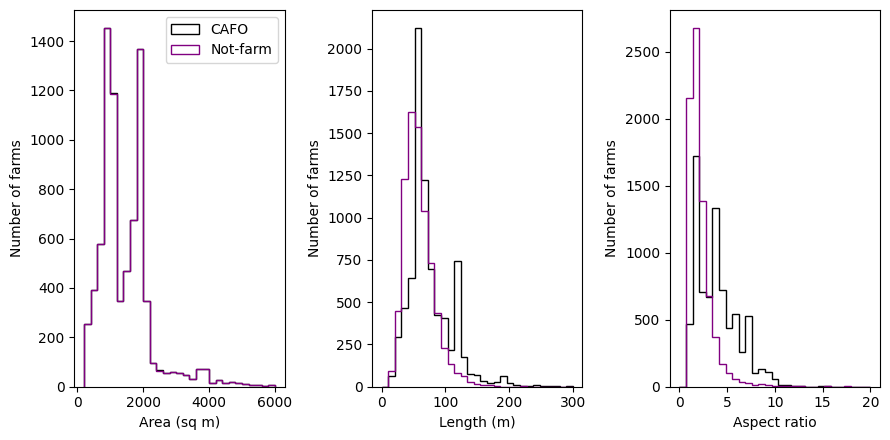

In [87]:

_, axes = plt.subplots(1, 3, figsize=(9, 4.5))

for bldg_type, label, color in zip([max_farm_bldgs, notfarm_buildings],\
                            ["CAFO", "Not-farm"], ['k', 'purple' ]):
  for col, ax in zip(["Area (sq m)", "Length (m)", "Aspect ratio"], axes):
    ax.hist(bldg_type[col], bins=bins[col], histtype="step",\
            color=color, label=label)
    if col == "Area (sq m)":
      ax.legend()
    ax.set_xlabel(col)
    ax.set_ylabel("Number of farms")

plt.tight_layout()

## Save the final dataset

In [88]:
# -- Farm buildings
max_farm_bldgs.loc[:, "Dataset name"] = "Iowa"
max_farm_bldgs = explore.re_order(max_farm_bldgs)
print(f"Saving {len(max_farm_bldgs)} farms")
display(max_farm_bldgs.head())

# -- Not-farm buildings
coldict = {"Dataset name": "Iowa", "Parent coords": None,\
           "Farm type": "Non-farm", "Number of animals": np.nan}
for col, val in coldict.items():
  notfarm_buildings.loc[:, col] = val

notfarm_buildings = explore.re_order(notfarm_buildings)
print(f"Saving {len(notfarm_buildings)} not-farms")

chl = pd.concat([max_farm_bldgs, notfarm_buildings])

max_farm_bldgs.to_pickle(f'/content/drive/MyDrive/CAFO_data/forTraining/interim_files/Iowa_bldgs.pkl')

Saving 7850 farms


,geometry,Area (sq m),Length (m),Aspect ratio,Parent coords,Farm type,Number of animals,Dataset name
0,"POLYGON ((-95.60194 43.21726, -95.60194 43.216...",43438,304,2,"POLYGON ((-95.598104 43.216644, -95.598114 43....",Unknown,NaN,Iowa
1,"POLYGON ((-93.91285 42.94820, -93.91283 42.950...",34979,304,2,"POLYGON ((-93.911772 42.948821, -93.911785 42....",Poultry,5047672,Iowa
2,"POLYGON ((-92.48573 42.35854, -92.48746 42.358...",33734,232,1,"POLYGON ((-92.484199 42.35578, -92.484214 42.3...",Pig,2450,Iowa
3,"POLYGON ((-94.64639 43.23826, -94.64635 43.240...",26199,269,1,"POLYGON ((-94.645684 43.239471, -94.645695 43....",Poultry,1297362,Iowa
4,"POLYGON ((-93.96385 42.77019, -93.96385 42.769...",23790,187,1,"POLYGON ((-93.963837 42.769441, -93.96385 42.7...",Poultry,1440000,Iowa


Saving 7736 not-farms
